In [72]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ViT

import trainer as train_funct
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


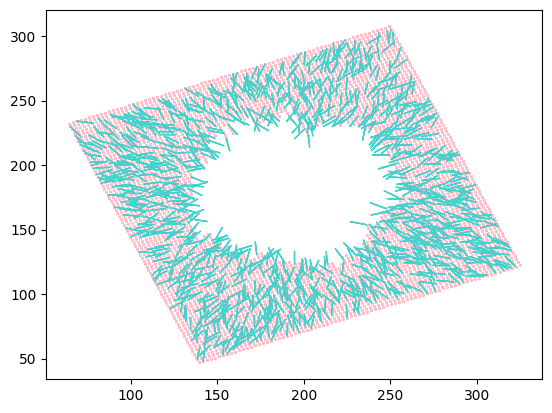

In [9]:
plotter.plot_train_data(train_data)

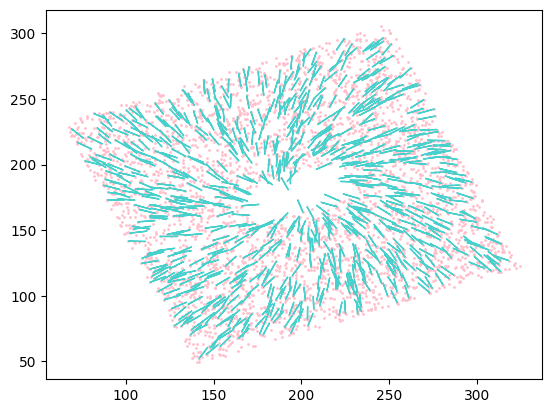

In [10]:
plotter.plot_data(val_data)

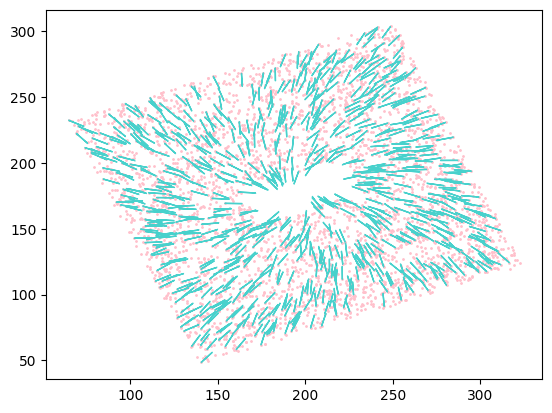

In [11]:
plotter.plot_data(test_data)

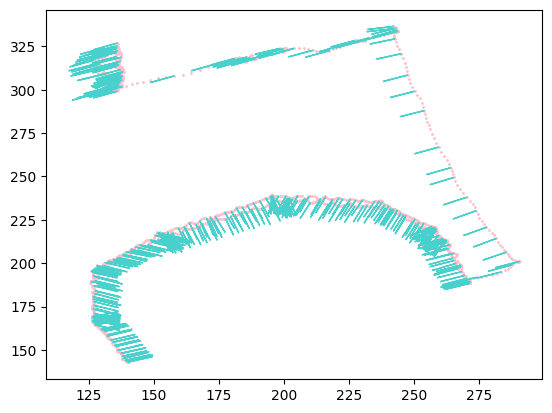

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


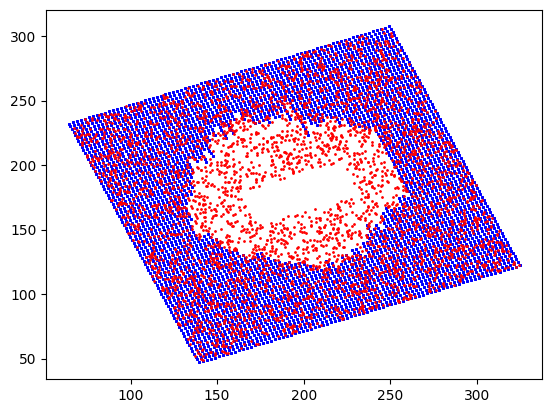

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2083.70it/s]


Validation after filtering: 3253


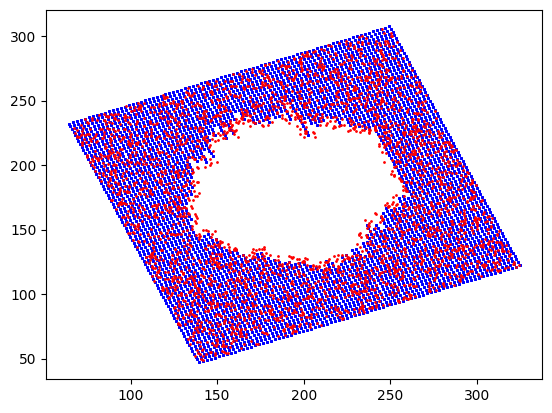

In [15]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


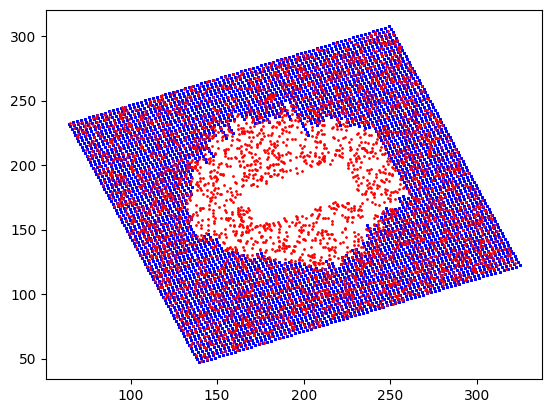

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2087.05it/s]


Test after filtering: 3271


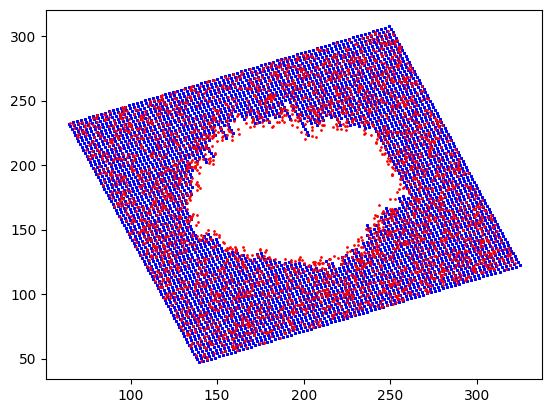

In [17]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9185888716281714
yaw difference tensor(7.2461) deg
localization error:  0.037775546 meters


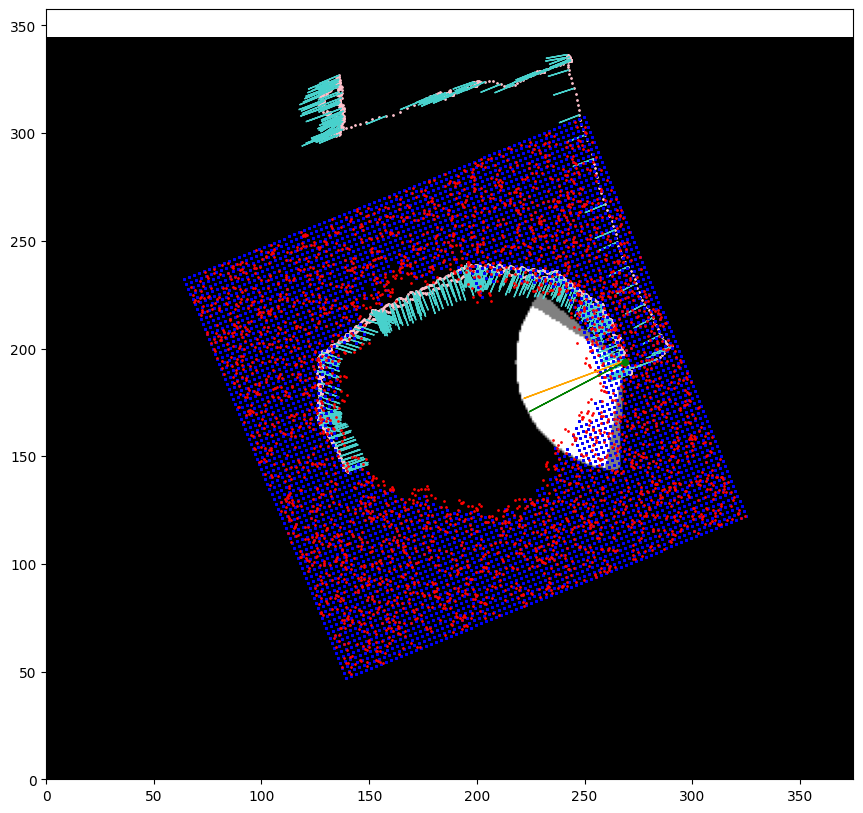

<Figure size 640x480 with 0 Axes>

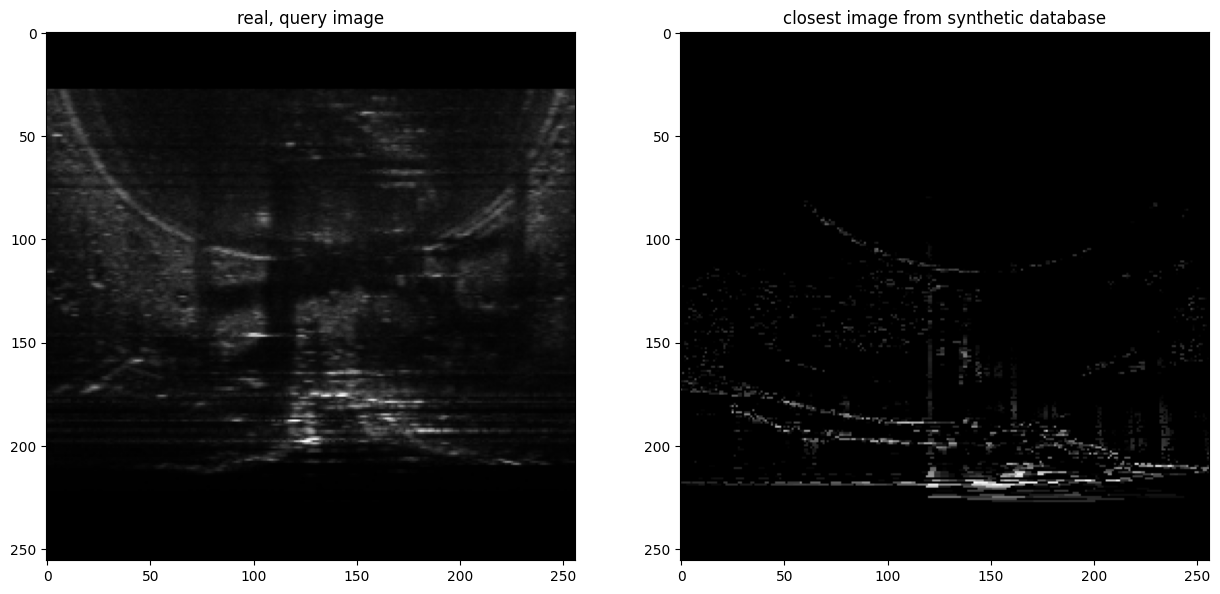

In [18]:
visualizer.localization(train_data, val_data, real_data)

In [19]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [20]:
val_data = visualizer.check_gt(train_data, val_data)

In [21]:
test_data = visualizer.check_gt(train_data, test_data)

In [22]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3267


In [23]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [24]:
model_name = "ViT"

In [73]:
net = ViT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [26]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [27]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  118576010


## Training Pipeline

### Train epochs

In [28]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1501/1501 [11:41<00:00,  2.14it/s]


train loss mean: 0.3740464893878896
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:38<00:00, 243.18it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:13<00:00, 242.38it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:20<00:00,  7.39it/s]


average localization error: 9.6335 meters
average orientation error : 77.8891 degrees
epoch: 2


 15%|██████▏                                 | 232/1501 [01:46<09:45,  2.17it/s]


KeyboardInterrupt: 

In [29]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.002187684178352356 seconds


In [30]:
metrics.get_descriptors(train_data, val_data, net)

100%|████████████████████████████████████| 24005/24005 [01:41<00:00, 236.15it/s]


computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [01:37<00:00, 246.64it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:13<00:00, 244.77it/s]


descriptors computed!
torch.Size([3251]) torch.Size([3251, 5])
avg_metric_e     : tensor(118.5945)
avg_metric_e_top5: tensor(51.6713)


## Visualize Training results on Test data

### Load the checkpoint model

In [32]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
net = ViT.Model()
train_funct.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [61]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  0%|                                       | 14/24005 [00:00<02:54, 137.42it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  0%|                                       | 36/24005 [00:00<02:09, 184.90it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])


  0%|                                       | 55/24005 [00:00<02:11, 182.29it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  0%|▏                                      | 78/24005 [00:00<02:00, 198.02it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  0%|▏                                      | 98/24005 [00:00<02:02, 195.32it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  0%|▏                                     | 120/24005 [00:00<01:59, 200.04it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  1%|▏                                     | 141/24005 [00:00<01:59, 200.11it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  1%|▎                                     | 164/24005 [00:00<01:54, 208.39it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  1%|▎                                     | 185/24005 [00:00<01:56, 204.97it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▎                                     | 207/24005 [00:01<01:53, 208.88it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▎                                     | 228/24005 [00:01<01:55, 206.05it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▍                                     | 250/24005 [00:01<01:53, 209.69it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▍                                     | 271/24005 [00:01<01:54, 207.55it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  1%|▍                                     | 293/24005 [00:01<01:52, 209.94it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▍                                     | 315/24005 [00:01<01:52, 210.08it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  1%|▌                                     | 337/24005 [00:01<01:51, 211.84it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  1%|▌                                     | 359/24005 [00:01<01:53, 208.81it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  2%|▌                                     | 381/24005 [00:01<01:51, 211.13it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  2%|▋                                     | 403/24005 [00:01<01:53, 208.79it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  2%|▋                                     | 447/24005 [00:02<01:52, 209.94it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  2%|▊                                     | 491/24005 [00:02<01:51, 210.15it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  2%|▊                                     | 536/24005 [00:02<01:49, 214.26it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  2%|▉                                     | 581/24005 [00:02<01:51, 209.16it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  3%|▉                                     | 624/24005 [00:03<01:56, 201.13it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  3%|█                                     | 667/24005 [00:03<01:54, 203.14it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  3%|█▏                                    | 715/24005 [00:03<01:45, 221.13it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  3%|█▏                                    | 766/24005 [00:03<01:38, 236.73it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  3%|█▎                                    | 816/24005 [00:03<01:36, 240.27it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  4%|█▎                                    | 866/24005 [00:04<01:36, 239.73it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  4%|█▍                                    | 890/24005 [00:04<01:36, 238.59it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  4%|█▍                                    | 914/24005 [00:04<01:38, 234.90it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  4%|█▍                                    | 938/24005 [00:04<01:39, 230.99it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  4%|█▌                                    | 962/24005 [00:04<01:39, 232.06it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  4%|█▌                                    | 986/24005 [00:04<01:38, 233.14it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  4%|█▌                                   | 1010/24005 [00:04<01:38, 233.48it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  4%|█▌                                   | 1034/24005 [00:04<01:38, 233.92it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  4%|█▋                                   | 1058/24005 [00:04<01:40, 229.27it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  5%|█▋                                   | 1081/24005 [00:05<01:45, 216.68it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  5%|█▋                                   | 1105/24005 [00:05<01:42, 223.12it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  5%|█▋                                   | 1129/24005 [00:05<01:40, 226.94it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  5%|█▊                                   | 1153/24005 [00:05<01:39, 230.31it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  5%|█▊                                   | 1178/24005 [00:05<01:37, 235.29it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  5%|█▉                                   | 1226/24005 [00:05<01:41, 223.38it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  5%|█▉                                   | 1272/24005 [00:05<01:41, 223.69it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  5%|██                                   | 1318/24005 [00:06<01:44, 216.11it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagi

  6%|██                                   | 1363/24005 [00:06<01:43, 219.12it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  6%|██▏                                  | 1407/24005 [00:06<01:43, 217.57it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

  6%|██▏                                  | 1430/24005 [00:06<01:43, 217.40it/s]

Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
Forma dell'immagine p

KeyboardInterrupt: 

### Visualize query results: sonar images

In [34]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 256, 4, 4]) tensor(-0.8246, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7893, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 8, 8]) tensor(-0.9489, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0972, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 16, 16]) tensor(-2.2145, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.1453, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 32, 32]) tensor(-1.8719, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.5414, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0279, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.1498, device='cuda:0', grad_fn=<MaxBackward1>)


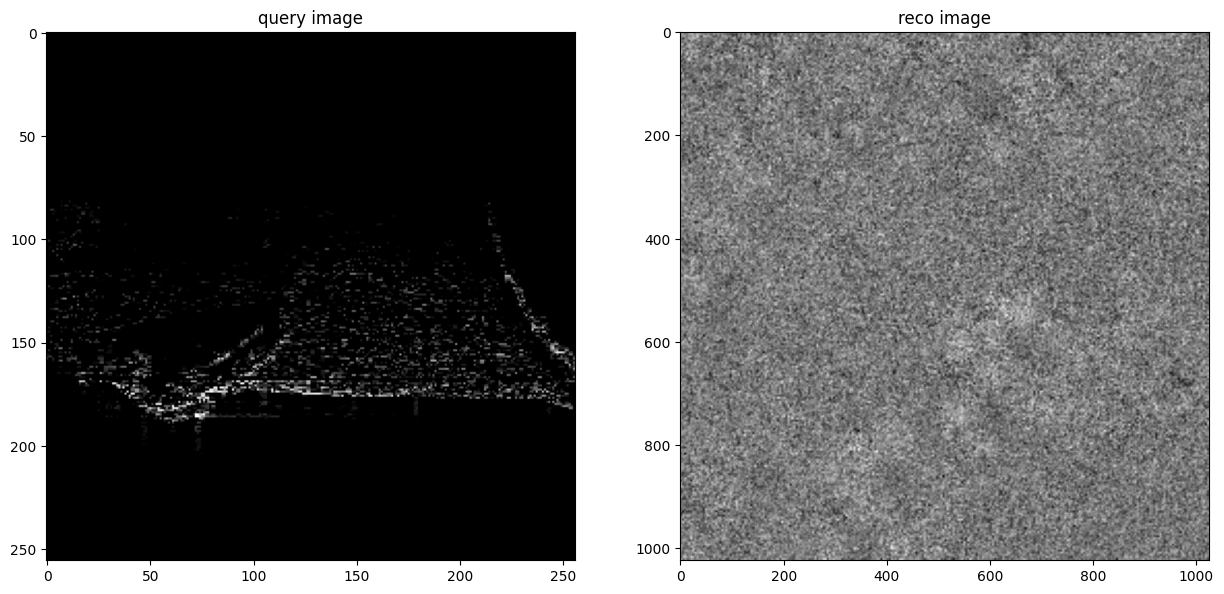

In [35]:
visualizer.analyze_feature_robustness(train_data, net)

Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
SIZE:  torch.Size([1, 256, 256])
iou: 0.23820521961960478
localization error: 5.2559 meters
orientation error : 2.5601 degrees


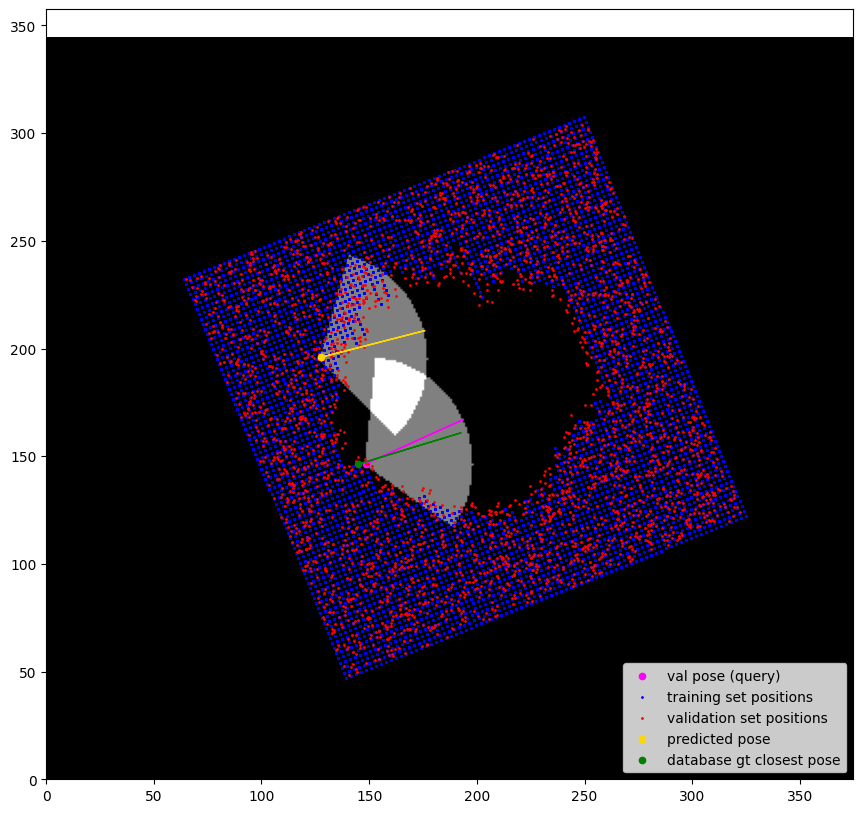

<Figure size 640x480 with 0 Axes>

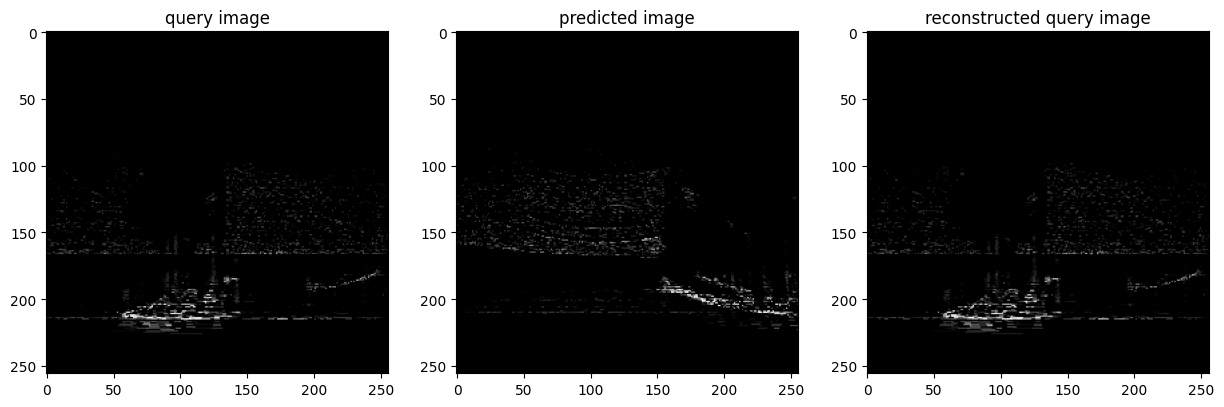

In [48]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [59]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

  0%|                                          | 1/3267 [00:00<09:48,  5.55it/s]

Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|                                          | 3/3267 [00:00<07:59,  6.81it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|                                          | 5/3267 [00:00<07:38,  7.12it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|                                          | 7/3267 [00:01<07:33,  7.19it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|                                          | 9/3267 [00:01<07:25,  7.31it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|▏                                        | 11/3267 [00:01<07:21,  7.37it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|▏                                        | 13/3267 [00:01<07:18,  7.41it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  0%|▏                                        | 15/3267 [00:02<07:22,  7.34it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▏                                        | 17/3267 [00:02<07:20,  7.39it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▏                                        | 19/3267 [00:02<07:14,  7.48it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▎                                        | 21/3267 [00:02<07:14,  7.47it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▎                                        | 23/3267 [00:03<07:17,  7.41it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▎                                        | 25/3267 [00:03<07:44,  6.98it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▎                                        | 27/3267 [00:03<07:32,  7.16it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▎                                        | 29/3267 [00:04<07:22,  7.32it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▍                                        | 31/3267 [00:04<07:18,  7.38it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▍                                        | 33/3267 [00:04<07:17,  7.40it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▍                                        | 35/3267 [00:04<07:12,  7.47it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▍                                        | 37/3267 [00:05<07:07,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▍                                        | 39/3267 [00:05<07:06,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▌                                        | 41/3267 [00:05<07:04,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▌                                        | 43/3267 [00:05<07:03,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▌                                        | 45/3267 [00:06<07:04,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▌                                        | 47/3267 [00:06<07:05,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  1%|▌                                        | 49/3267 [00:06<07:03,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▋                                        | 51/3267 [00:06<07:06,  7.54it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▋                                        | 53/3267 [00:07<07:05,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▋                                        | 55/3267 [00:07<07:03,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▋                                        | 57/3267 [00:07<07:01,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▋                                        | 59/3267 [00:07<07:02,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▊                                        | 61/3267 [00:08<07:00,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▊                                        | 63/3267 [00:08<06:59,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▊                                        | 65/3267 [00:08<07:03,  7.55it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▊                                        | 67/3267 [00:09<07:00,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▊                                        | 69/3267 [00:09<07:01,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▉                                        | 71/3267 [00:09<07:30,  7.09it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▉                                        | 73/3267 [00:09<07:14,  7.35it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▉                                        | 75/3267 [00:10<07:08,  7.45it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▉                                        | 77/3267 [00:10<07:07,  7.46it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|▉                                        | 79/3267 [00:10<07:01,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  2%|█                                        | 81/3267 [00:10<06:59,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█                                        | 83/3267 [00:11<06:59,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█                                        | 85/3267 [00:11<06:58,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█                                        | 87/3267 [00:11<06:58,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█                                        | 89/3267 [00:11<06:58,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                       | 91/3267 [00:12<07:02,  7.52it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                       | 93/3267 [00:12<07:30,  7.05it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                       | 95/3267 [00:12<07:10,  7.36it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                       | 97/3267 [00:13<07:05,  7.46it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                       | 99/3267 [00:13<07:01,  7.52it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▏                                      | 101/3267 [00:13<06:57,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▎                                      | 103/3267 [00:13<06:55,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▎                                      | 105/3267 [00:14<06:53,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▎                                      | 107/3267 [00:14<06:54,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▎                                      | 109/3267 [00:14<06:53,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▎                                      | 111/3267 [00:14<07:37,  6.90it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  3%|█▍                                      | 113/3267 [00:15<07:15,  7.24it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▍                                      | 115/3267 [00:15<07:03,  7.43it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▍                                      | 117/3267 [00:15<07:00,  7.49it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▍                                      | 119/3267 [00:16<06:55,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▍                                      | 121/3267 [00:16<06:52,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▌                                      | 123/3267 [00:16<06:49,  7.68it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▌                                      | 125/3267 [00:16<06:52,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▌                                      | 127/3267 [00:17<07:30,  6.98it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▌                                      | 129/3267 [00:17<07:10,  7.30it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▌                                      | 131/3267 [00:17<06:59,  7.48it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▋                                      | 133/3267 [00:17<06:54,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▋                                      | 135/3267 [00:18<06:53,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▋                                      | 137/3267 [00:18<06:52,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▋                                      | 139/3267 [00:18<06:52,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▋                                      | 141/3267 [00:18<06:51,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▊                                      | 143/3267 [00:19<06:51,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▊                                      | 145/3267 [00:19<06:50,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  4%|█▊                                      | 147/3267 [00:19<06:47,  7.65it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▊                                      | 149/3267 [00:19<06:47,  7.66it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▊                                      | 151/3267 [00:20<06:49,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▊                                      | 153/3267 [00:20<06:47,  7.65it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▉                                      | 155/3267 [00:20<06:46,  7.65it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▉                                      | 157/3267 [00:21<06:48,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▉                                      | 159/3267 [00:21<06:51,  7.55it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▉                                      | 161/3267 [00:21<06:46,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|█▉                                      | 163/3267 [00:21<07:22,  7.01it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██                                      | 165/3267 [00:22<07:06,  7.27it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██                                      | 167/3267 [00:22<06:57,  7.43it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██                                      | 169/3267 [00:22<06:52,  7.51it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██                                      | 171/3267 [00:22<06:48,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██                                      | 173/3267 [00:23<06:48,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██▏                                     | 175/3267 [00:23<06:46,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██▏                                     | 177/3267 [00:23<06:48,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  5%|██▏                                     | 179/3267 [00:23<06:49,  7.55it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▏                                     | 181/3267 [00:24<06:51,  7.50it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▏                                     | 183/3267 [00:24<06:46,  7.59it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▎                                     | 185/3267 [00:24<06:43,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▎                                     | 187/3267 [00:25<06:43,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▎                                     | 189/3267 [00:25<06:40,  7.69it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▎                                     | 191/3267 [00:25<06:44,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▎                                     | 193/3267 [00:25<06:42,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▍                                     | 195/3267 [00:26<07:10,  7.14it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▍                                     | 197/3267 [00:26<06:56,  7.37it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▍                                     | 199/3267 [00:26<06:48,  7.51it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▍                                     | 201/3267 [00:26<06:45,  7.56it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▍                                     | 203/3267 [00:27<06:46,  7.54it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▌                                     | 205/3267 [00:27<06:49,  7.49it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▌                                     | 207/3267 [00:27<06:45,  7.54it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▌                                     | 209/3267 [00:27<06:46,  7.52it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  6%|██▌                                     | 211/3267 [00:28<06:47,  7.50it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▌                                     | 213/3267 [00:28<06:46,  7.51it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▋                                     | 215/3267 [00:28<06:44,  7.55it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▋                                     | 217/3267 [00:29<06:41,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▋                                     | 219/3267 [00:29<06:38,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▋                                     | 221/3267 [00:29<06:35,  7.70it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▋                                     | 223/3267 [00:29<06:38,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▊                                     | 225/3267 [00:30<06:38,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▊                                     | 227/3267 [00:30<06:40,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▊                                     | 229/3267 [00:30<06:41,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▊                                     | 231/3267 [00:30<06:37,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▊                                     | 233/3267 [00:31<07:09,  7.06it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 235/3267 [00:31<06:57,  7.26it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 237/3267 [00:31<06:45,  7.47it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 239/3267 [00:31<06:39,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 241/3267 [00:32<06:36,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 243/3267 [00:32<06:37,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  7%|██▉                                     | 245/3267 [00:32<06:33,  7.67it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███                                     | 247/3267 [00:33<06:35,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███                                     | 249/3267 [00:33<06:35,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███                                     | 251/3267 [00:33<06:33,  7.66it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███                                     | 253/3267 [00:33<06:34,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███                                     | 255/3267 [00:34<06:38,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▏                                    | 257/3267 [00:34<06:39,  7.54it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▏                                    | 259/3267 [00:34<06:37,  7.57it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▏                                    | 261/3267 [00:34<06:36,  7.58it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▏                                    | 263/3267 [00:35<06:33,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▏                                    | 265/3267 [00:35<06:37,  7.55it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▎                                    | 267/3267 [00:35<06:34,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▎                                    | 269/3267 [00:35<06:32,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▎                                    | 271/3267 [00:36<06:33,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▎                                    | 273/3267 [00:36<06:31,  7.66it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▎                                    | 275/3267 [00:36<06:32,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  8%|███▍                                    | 277/3267 [00:36<06:31,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▍                                    | 279/3267 [00:37<06:32,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▍                                    | 281/3267 [00:37<06:31,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▍                                    | 283/3267 [00:37<06:31,  7.62it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▍                                    | 285/3267 [00:38<06:57,  7.13it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▌                                    | 287/3267 [00:38<06:48,  7.30it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▌                                    | 289/3267 [00:38<06:37,  7.49it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▌                                    | 291/3267 [00:38<06:37,  7.49it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▌                                    | 293/3267 [00:39<06:34,  7.53it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▌                                    | 295/3267 [00:39<06:30,  7.61it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▋                                    | 297/3267 [00:39<06:29,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▋                                    | 299/3267 [00:39<06:28,  7.64it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▋                                    | 301/3267 [00:40<06:30,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▋                                    | 303/3267 [00:40<06:28,  7.63it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▋                                    | 305/3267 [00:40<06:24,  7.70it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▊                                    | 307/3267 [00:40<06:25,  7.67it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


  9%|███▊                                    | 309/3267 [00:41<06:29,  7.60it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▊                                    | 311/3267 [00:41<07:03,  6.98it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▊                                    | 313/3267 [00:41<06:50,  7.19it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▊                                    | 315/3267 [00:42<06:43,  7.31it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▉                                    | 317/3267 [00:42<06:41,  7.35it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▉                                    | 319/3267 [00:42<06:42,  7.32it/s]

SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])
SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


 10%|███▉                                    | 320/3267 [00:42<06:33,  7.49it/s]


SIZE:  torch.Size([1, 256, 256])
Forma dell'immagine prima di ViT: torch.Size([1, 2, 256, 256])
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
Forma dell'immagine dopo ViT: torch.Size([1, 256, 16, 16])


KeyboardInterrupt: 

In [38]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [39]:
loca_errors.argmax()

np.int64(1220)

In [40]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

5.1372056
5.156356


## Process real images

query_idx: 104
Forma dell'immagine in ingresso: torch.Size([1, 2, 256, 256])
185.05005 229.5401 2.361446 -44.699112
iou: 0.06298253058540111
localization error Upper:  6.661715 meters


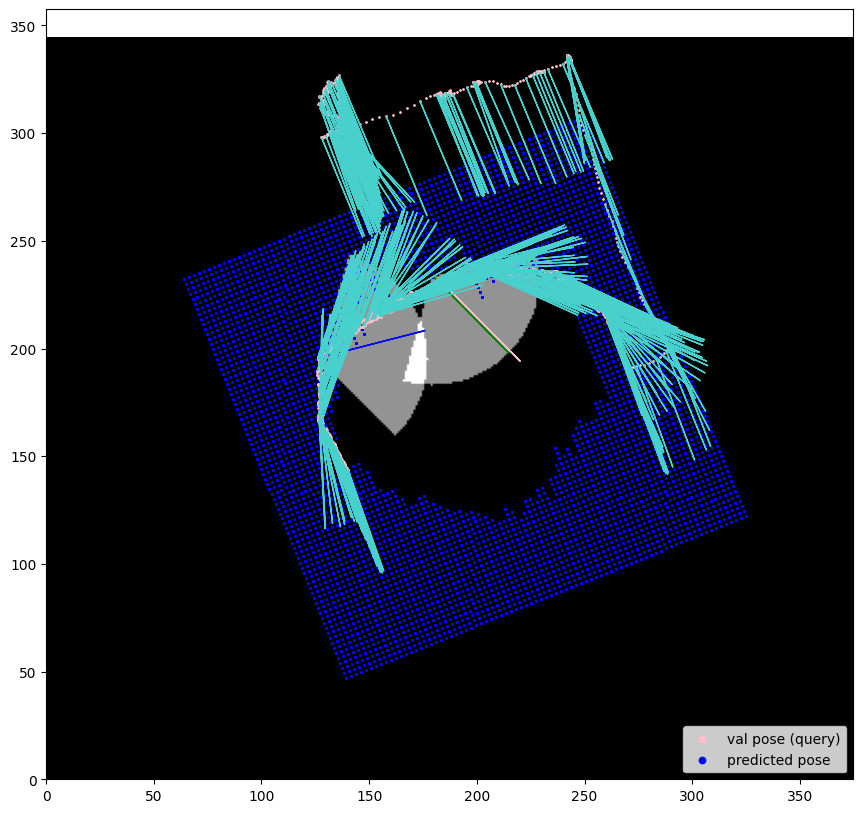

<Figure size 640x480 with 0 Axes>

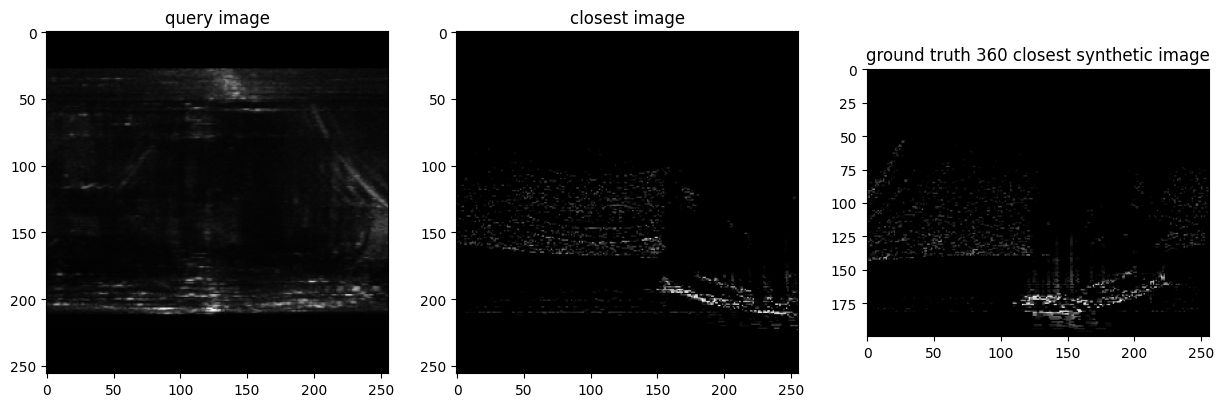

In [60]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [51]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [64]:
# Ottieni il primo esempio dal dataset
first_sample = real_data_train[0]

# Stampa il tipo e la struttura del risultato
print("Tipo di first_sample:", type(first_sample))
print("Contenuto di first_sample:", first_sample)


Tipo di first_sample: <class 'tuple'>
Contenuto di first_sample: (tensor([[[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         ...,
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00]],

        [[-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          -4.3711e-08, -4.3711e-08],
         [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          -4.3711e-08, -4.3711e-08],
         [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
          

In [74]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████████| 710/710 [00:03<00:00, 222.17it/s]

descriptors computed!


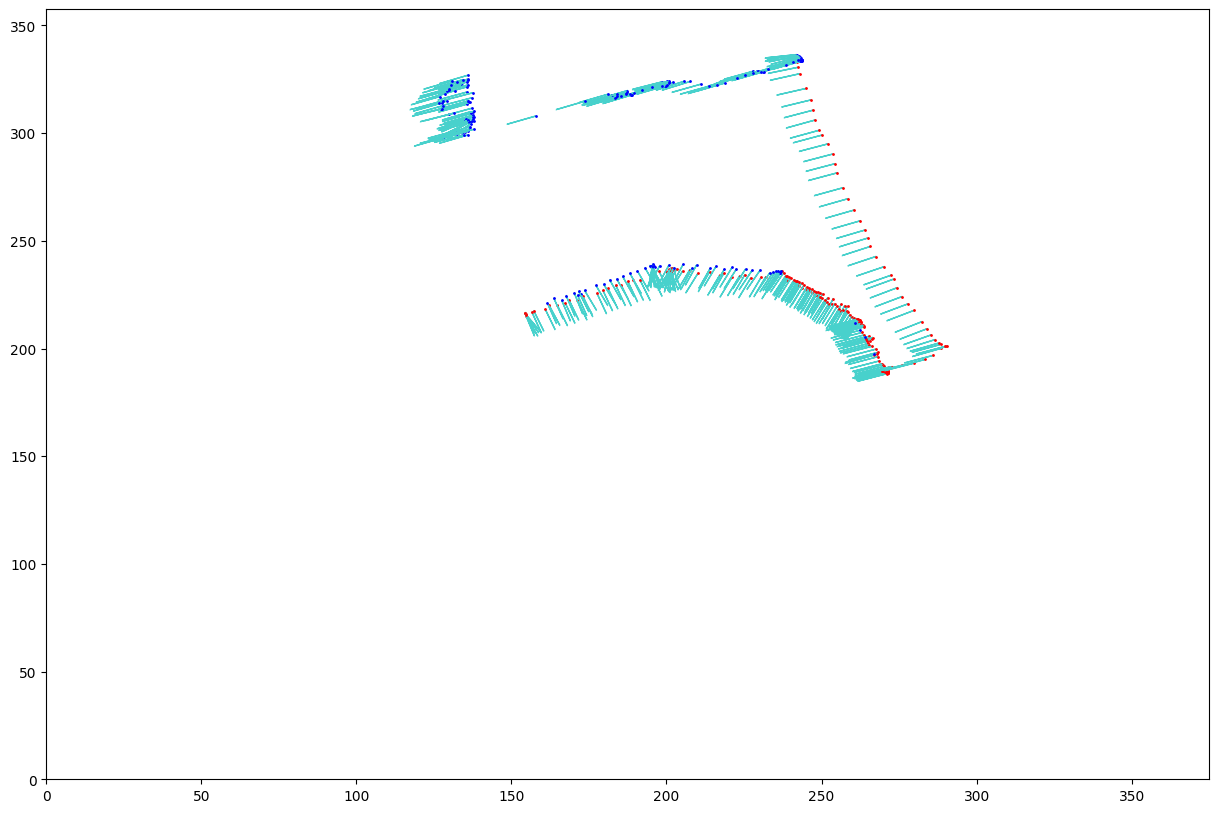

In [75]:
visualizer.visualize_real(train_data, real_data)

iou: 0.33101005809757084
localization error: 4.9554 meters
orientation error : 41.0639 degrees


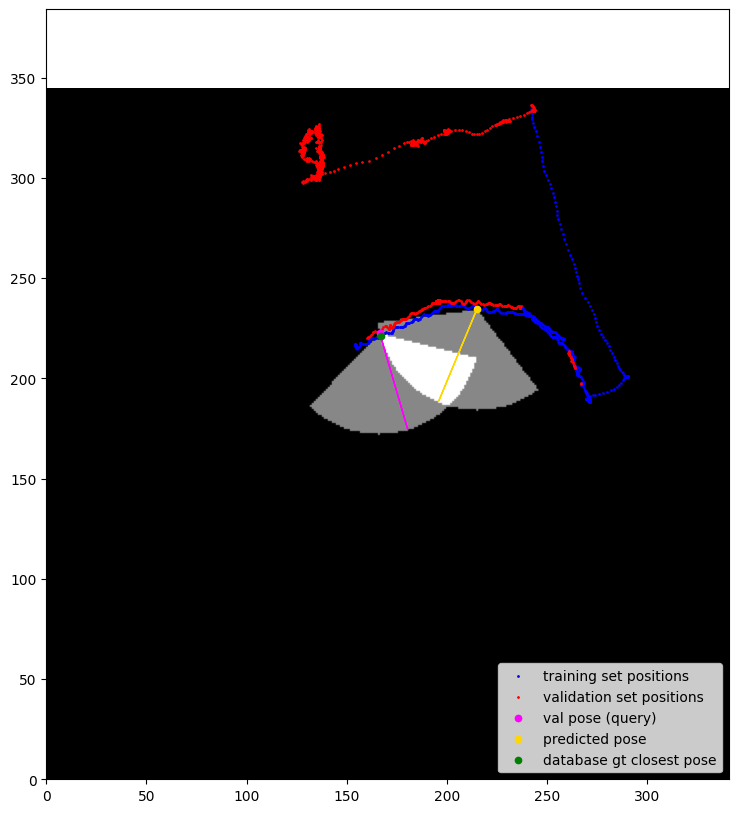

<Figure size 640x480 with 0 Axes>

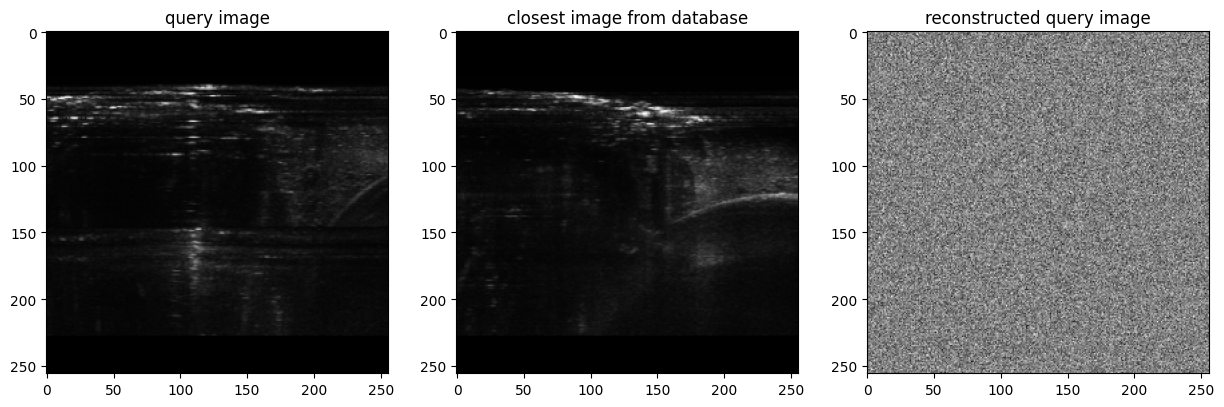

In [76]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [77]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:15<00:00, 49.54it/s]

average localization error: 5.7578 meters
average orientation error : 37.9381 degrees


In [78]:
avg_orie_error.min()

np.float32(37.93807)

## Results

In [ ]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")